In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import anderson, shapiro
import statsmodels.api as sm
from astropy.coordinates import SkyCoord as coord
import astropy.units as u

Data source: https://www.herta-experiment.org/frbstats/

### Structure of data in the catalogue

In [2]:
df_frb = pd.read_csv('/home/anojkhadka/Desktop/frb_summerresearch//herta_frb_catalogue.csv', delimiter = ',', usecols = ['frb', 'utc', 'mjd', 'telescope', 'ra', 'dec', 'l', 'b', 'frequency','dm', 'flux', 'width', 'fluence',  'redshift'])
print('There are', len(df_frb), 'FRBs in the catalouge')

df_frb.head(1)

There are 806 FRBs in the catalouge


,frb,utc,mjd,telescope,ra,dec,l,b,frequency,dm,flux,width,fluence,redshift
0,FRB 20010125A,2001-01-25 0:29:16,51934.02032,Parkes,19:06:53,-40:37:14,356.64,-20.02,-,790.3,0.54,-,-,0.7083


<font color = green>####################### ROW_INDEX_IDENTIFIER_FUNCTION   #############################</font>

This code snippet will be useful to find the row number by putting the FRB name from the catalogue. Why do I need this? This will be handy to extract all the available information for any given FRB if know its name.

In [3]:
def frb_index(name):
    
    for n in np.arange(0, len(df_frb['frb'])):
        if df_frb.loc[n, 'frb'] == name:
            index_no = n
            print(index_no)
        else:
            continue

        
    df_frb.loc[index_no]

frb_index('FRB 20010724A')         # I can pick the row index of 'FRB 20190608A' using above function.

4


<font color = green>###############################################################################</font>

### Segregating repeating FRBs from the catalouge

In [6]:
# This list contains all the FRB that are classified as repeaters in site below.
# https://www.herta-experiment.org/frbstats/repeaters

repeater_list = ['FRB 20121102A', 'FRB 20180814A', 'FRB 20180908A', 'FRB 20180916B', 'FRB 20181017A' ,'FRB 20181030A' ,'FRB 20181119A' ,'FRB 20181119C' , 'FRB 20181128A', 'FRB 20181225B' , 'FRB 20190107B', 'FRB 20190116A' , 'FRB 20190117A', 'FRB 20190208A', 'FRB 20190209A', 'FRB 20190212A', 'FRB 20190213A' , 'FRB 20190222A', 'FRB 20190303A', 'FRB 20190417A', 'FRB 20190604A', 'FRB 20190711A', 'FRB 20190907A', 'FRB 20200120E', 'FRB 20201124A']
repeater_index = []

# This block of code acts as a unit testing to see if repeaters listed in above list lies in the catalogue or not.

for k1 in np.arange(0, len(df_frb['frb'])):
    for k2 in np.arange(0, len(repeater_list)):
        if repeater_list[k2] == df_frb['frb'][k1]:
            repeater_index.append(k1)
            
print('There are', len(repeater_list), 'repeating FRBs in the catalogue \n')



                       ############# Creating a separate dataframe of  FRB repeaters ###########    
    
df_frb_repeater = df_frb.loc[repeater_index]  # This dataframe will conatin all repeating FRBs 

                        ####################~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#####################
    
                    
        
                    ############# Removing frbs that has no values for pulse width ###########   
            
# How do I know the numbers in the list below? Just pull the df_frb_repeater dataframe and it will show missing 
# datas for pulse width fluence for FRBs with listed row index. Since we just need to look into small number of
# data it can easily be identified by just looking into the dataframe.

df_frb_repeater_clean = df_frb_repeater.drop([114, 659, 673, 718, 765])  # This dataframe has 20 repeaters.

print('Only', len(df_frb_repeater_clean), 'repeating FRBs have values for pulse wdith.')

                    ####################~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#####################

There are 25 repeating FRBs in the catalogue 

Only 20 repeating FRBs have values for pulse wdith.


### Segregating non-repeating FRBs from main catalogue. 

I have also excluded those FRBs with no value available for 'width' and 'flux'.

In [8]:
non_repeater_index = []

for ind1 in np.arange(0, len(df_frb)):
      
    if ind1 not in repeater_index:
        non_repeater_index.append(ind1)
# print(non_repeater_index)
print('\n There are ', len(non_repeater_index), 'non-repeating FRBs in the catalogue.')

   ######################Creating dataframe for non-repeating FRBs################################################

df_non_repeating_frb = df_frb.loc[non_repeater_index]
df_non_repeating_frb
df_non_repeating_frb.head(1)


 There are  781 non-repeating FRBs in the catalogue.


,frb,utc,mjd,telescope,ra,dec,l,b,frequency,dm,flux,width,fluence,redshift
0,FRB 20010125A,2001-01-25 0:29:16,51934.02032,Parkes,19:06:53,-40:37:14,356.64,-20.02,-,790.3,0.54,-,-,0.7083


Dispersion measure  data for 25 new repeater is taken from "CHIME/FRB Discovery of 25 Repeating Fast Radio Burst Sources"  Bridget et al, 2023 paper. 

In [11]:
DM_of_new25repeater = [287.984, 333.40, 439.772, 363.68, 488.69, 413.659, 510.42, 1703.48, 
                  479.602, 632.597, 202.268, 722.37, 400.57, 671.5, 351.3, 322.23, 
                  221.92, 625.57, 241.887, 523.57, 552.47, 428.90, 576.880, 758.44, 
                  684.408]

combined_list_DM  = list(df_frb_repeater['dm'].values) + DM_of_new25repeater

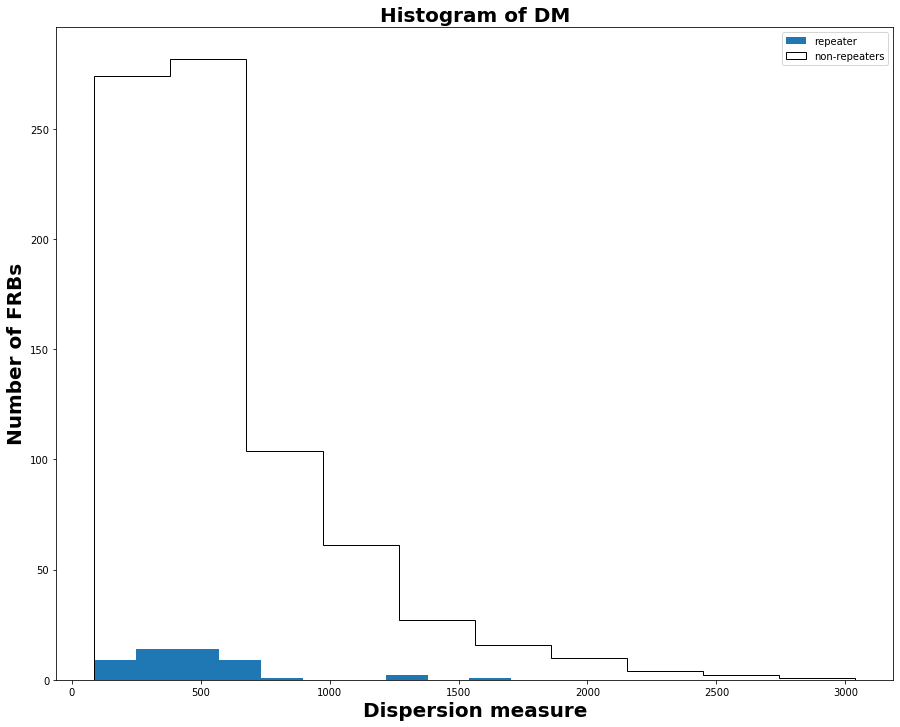

In [43]:
fig, repeater_DM_histogram = plt.subplots(1, 1, figsize= (15,12))
repeater_DM_histogram.hist(combined_list_DM,  alpha = 1, label = 'repeater')
repeater_DM_histogram.hist(df_non_repeating_frb['dm'], histtype = 'step', color = 'black', label = 'non-repeaters')
repeater_DM_histogram.set_xlabel('Dispersion measure', size = 20, weight = 'bold')
repeater_DM_histogram.set_ylabel('Number of FRBs', size = 20, weight = 'bold')
repeater_DM_histogram.legend()
repeater_DM_histogram.set_title('Histogram of DM', size = 20, weight = 'bold')
plt.show()

In [89]:
herta_nonrep_pwidth = df_non_repeating_frb['width']

herta_obs_nonrep_pwidth = []

for ind in np.arange(0, len(herta_nonrep_pwidth)):
    herta_obs_nonrep_pwidth.append(float(herta_nonrep_pwidth.values[ind]))

In [92]:
anderson(np.log(herta_obs_nonrep_pwidth))

AndersonResult(statistic=13.931291175538036, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [93]:
shapiro(np.log(herta_obs_nonrep_pwidth))

ShapiroResult(statistic=0.875940203666687, pvalue=1.5597846533137848e-21)

<font color = red>For non-repeating FRBs in HeRTA catalogue log normalized observed pulsewidth does not show normal distribution.</font>

# Friday Note EndPoint

In [40]:
tel_counter = 0
for count1 in np.arange(0, len(df_non_repeating_frb['telescope'])):
    if df_non_repeating_frb.iloc[count1, 3] == 'Pushchino LPA':
        tel_counter +=1
                        
print(tel_counter)

10


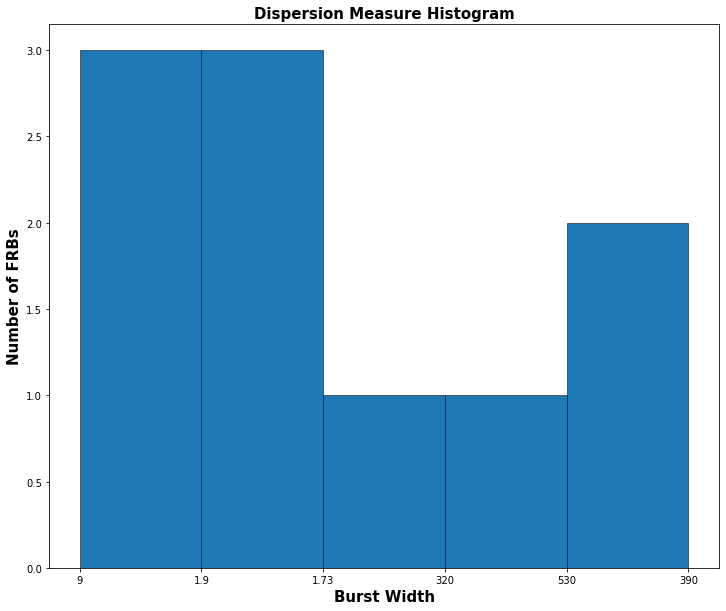

In [41]:
fig, ax_dm_hist = plt.subplots(figsize = (12, 10))
ax_dm_hist.hist(df_non_repeating_frb['width'], bins='auto', range = [0,5], linewidth=0.5, edgecolor="black")
ax_dm_hist.set_xlabel('Burst Width', size = 15, weight = 'bold')
ax_dm_hist.set_ylabel('Number of FRBs', size = 15, weight = 'bold')
ax_dm_hist.set_title('Dispersion Measure Histogram', size = 15, weight = 'bold')
plt.show()

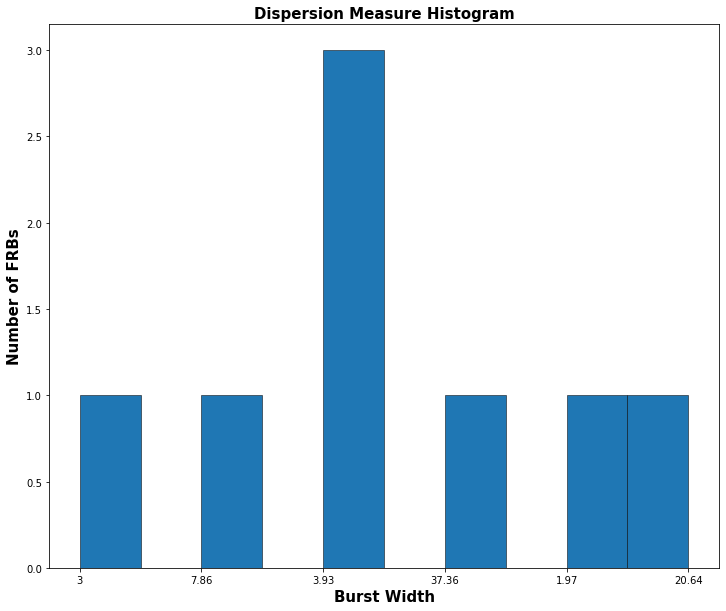

In [42]:
fig, ax_dm_hist = plt.subplots(figsize = (12, 10))
ax_dm_hist.hist(df_frb_repeater_with_non_empty_val['width'], bins=10, range = [0,5], linewidth=0.5, edgecolor="black")
ax_dm_hist.set_xlabel('Burst Width', size = 15, weight = 'bold')
ax_dm_hist.set_ylabel('Number of FRBs', size = 15, weight = 'bold')
ax_dm_hist.set_title('Dispersion Measure Histogram', size = 15, weight = 'bold')
plt.show()

In [23]:
df_frb_repeater_with_non_empty_val['width'].values

NameError: name 'df_frb_repeater_with_non_empty_val' is not defined

In [24]:
for j in np.arange(0, len(df_frb['frb'])):
    
    if df_frb.iloc[j, 0] == 'FRB 20180908A':
        print(j)
                

NameError: name 'df_frb' is not defined

In [25]:
def intrinsic_width(disp_measure, freq_channel_bandwidth, central_freq, sampling_time, Obs_time):
    
    t_DM = 8.3*0.001*disp_measure*(freq_channel_bandwidth/(central_freq)^3)
    
    intrinsic_time = np.sqrt(obs_time**2 - t_DM**2 - sampling_time**2)

In [26]:
df_frb[1:9]

NameError: name 'df_frb' is not defined

In [27]:
column_names = ['source', 'Observed_width', 'intrinsic_width', 'flux', 'fluence', 'distance']

df_repeaters = pd.DataFrame(columns= column_names)

In [28]:
df_repeaters

,source,Observed_width,intrinsic_width,flux,fluence,distance


### Histogram of pulse width (Made using the data from the authors table)

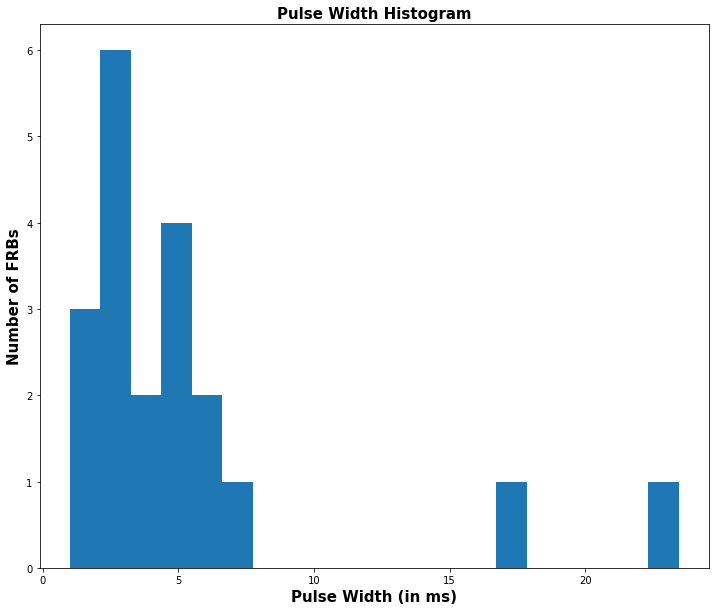

In [43]:
pwidth_fromauthor = [4.82, 23.45, 4.62, 5.27, 1.01, 5.90, 3.49, 2.75, 16.8, 6.55, 2.71, 1.11, 3.83, 2.10, 3.10, 
                     3.20, 4.50, 2.74, 7.00, 2.18]
fig, ax_pwidth_author = plt.subplots(figsize = (12, 10))
ax_pwidth_author.hist(pwidth_fromauthor, bins = 20)
ax_pwidth_author.set_ylabel('Number of FRBs', size = 15, weight = 'bold')
ax_pwidth_author.set_xlabel('Pulse Width (in ms)', size = 15, weight = 'bold')
ax_pwidth_author.set_title('Pulse Width Histogram', size = 15, weight = 'bold')
plt.show()

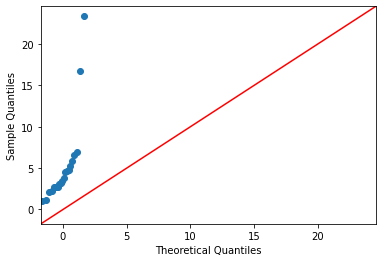

In [45]:
fig_repeater_from_paper = sm.qqplot(np.array(pwidth_fromauthor), line = '45')
plt.show()

### Trying AD test for sample of repeating FRB data

In [47]:
anderson(np.log(pwidth_fromauthor))

AndersonResult(statistic=0.4297467433047828, critical_values=array([0.506, 0.577, 0.692, 0.807, 0.96 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

<font color = 'red'>This sample of data is also exactly as used by authors. They have also indicated in the paper that AD test for repeater set of data gives negative test hypothesis i.e. data for pulse width of repeating FRBs does not show normal ditribution. Test above also shows test statistic refutes that data is normally distributed. </font>

In [32]:
table_one = pd.DataFrame(columns = ['source', 'observed_width', 'intrinsic_width', 'flux_density', 'fluence'])

In [33]:
repeater_source_names = ['FRB 20200120E', 'FRB 20201129A', 'FRB 20200718A'] 



# Create empty list to store data with their respective values.

observed_width = 0
flux_density = 0
fluence = 0
total_sample = 0

for a1 in np.arange(0 , len(repeater_source_names)):
    name = repeater_source_names[a1].replace('_', ' ')    # To match with the name in catalouge
    
    print('Loop No', a1)
    
    ind_no = list(df_frb['frb']).index(name)
    
    print('FRB Index',ind_no)
    
    if df_frb.iloc[ind_no, 11] == '-':                 # Column for width is 11th column
        continue
    total_sample += 1
    observed_width += float(df_frb.iloc[ind_no, 11])
    
    print('Sample count ', total_sample)
    print('Observed width', observed_width)
    print('\n\n')


        
#     flux_density += float(df_frb.iloc[ind_no, 10])
    
#     print('flux_density', flux_density)
    
#     fluence += float(df_frb.iloc[ind_no, 12])
    
#     print('fluence', fluence)
    

mean_obs_width = observed_width/total_sample

# mean_flux_density = flux_density/len(repeater_source_names)

# mean_fluence = fluence/len(repeater_source_names) 

# table_one.iloc[0, 0] = repeater_source_names[a1]

# table_one.iloc[0, 1] = mean_obs_width

# table_one.iloc[0, 3] = mean_flux_density

# table_one.iloc[0, 4] = mean_fluence

    
print('Average width', mean_obs_width)

if repeater_source_names[0] not in pulse_width:
    pulse_width.append(repeater_source_names[0] )
    pulse_width.append(mean_obs_width)


Loop No 0


NameError: name 'df_frb' is not defined

In [34]:
df_frb.iloc[767]

NameError: name 'df_frb' is not defined

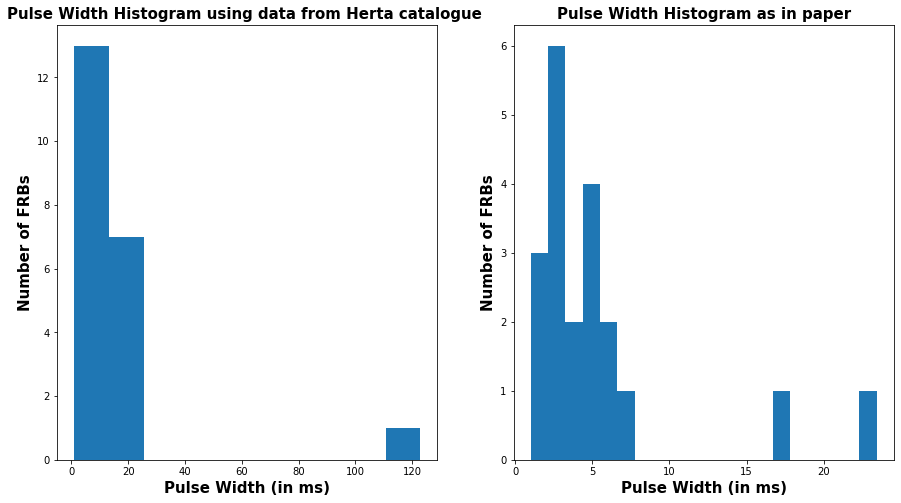

In [49]:
pulse_width = [4.81, 16.97, 13.76, 8.70, 122.88, 4.92, 2.46, 12.12, 16.05, 9.83, 12.78, 18.18, 4.92, 4.42, 13.76, 
               7.35, 17.2, 17.69, 6.88, 1, 2.15  ]

pwidth_fromauthor = [4.82, 23.45, 4.62, 5.27, 1.01, 5.90, 3.49, 2.75, 16.8, 6.55, 2.71, 1.11, 3.83, 2.10, 3.10, 
                     3.20, 4.50, 2.74, 7.00, 2.18]

fig, ax_pwidth_herta = plt.subplots(1, 2, figsize = (15, 8))
ax_pwidth_herta[0].hist(pulse_width, bins = 10)
ax_pwidth_herta[1].hist(pwidth_fromauthor, bins = 20)

ax_pwidth_herta[0].set_ylabel('Number of FRBs', size = 15, weight = 'bold')
ax_pwidth_herta[0].set_xlabel('Pulse Width (in ms)', size = 15, weight = 'bold')
ax_pwidth_herta[0].set_title('Pulse Width Histogram using data from Herta catalogue ', size = 15, weight = 'bold')

ax_pwidth_herta[1].set_ylabel('Number of FRBs', size = 15, weight = 'bold')
ax_pwidth_herta[1].set_xlabel('Pulse Width (in ms)', size = 15, weight = 'bold')
ax_pwidth_herta[1].set_title('Pulse Width Histogram as in paper', size = 15, weight = 'bold')
plt.savefig('/home/astroguy/Desktop/Research/repeater_comparison_plot.pdf')
plt.show()

In [50]:
rep_list = ['FRB 20121102A', 'FRB 20150517A', 'FRB 20170826A','FRB 20160823A', 'FRB 20151208A', 'FRB 20151119D', 
            'FRB 20151119C', 'FRB 20151119B', 'FRB 20151119A', 'FRB 20151113A', 'FRB 20150602H', 'FRB 20150602G', 
            'FRB 20150602F', 'FRB 20150602E', 'FRB 20150602D', 'FRB 20150602C', 'FRB 20150602B', 'FRB 20150602A', 
            'FRB 20150517B', 'FRB 20180814A', 'FRB 20200224A', 'FRB 20191111A', 
            'FRB 20191107A', 'FRB 20191029A', 'FRB 20190817A', 'FRB 20190626A', 'FRB 20190625E', 'FRB 20190611A', 
            'FRB 20190517B', 'FRB 20190329A', 
 'FRB 20190224F', 'FRB 20181120C', 'FRB 20181118C', 'FRB 20181028A', 'FRB 20180919A', 'FRB 20180917A',
            'FRB 20180911C', 'FRB 20200302A', 'FRB 20180908A','FRB 20190718A', 
 'FRB 20190702A', 'FRB 20190621A', 'FRB 20180908B', 'FRB 20180916B', 'FRB 20200423A', 'FRB 20200324C', 'FRB 20200324B', 'FRB 20200324A', 'FRB 20200323B', 'FRB 20200323A', 
 'FRB 20200221A', 'FRB 20200220D', 'FRB 20200220C', 'FRB 20200220B', 'FRB 20200220A', 'FRB 20200219A', 'FRB 20200204E', 'FRB 20200204D', 'FRB 20200204C', 'FRB 20200204B',
 'FRB 20200203A', 'FRB 20200120D', 'FRB 20200120C', 'FRB 20200120B', 'FRB 20200120A', 'FRB 20191219E', 'FRB 20191219D', 'FRB 20191219C', 'FRB 20191219B', 'FRB 20191219A', 
 'FRB 20191218A', 'FRB 20191115A', 'FRB 20191030B',
'FRB 20191030A', F'RB 20190825C', 'FRB 20190825B', 'FRB 20190825A', 'FRB 20190810B',  'FRB 20190809A', 'FRB 20190619H', 'FRB 20190619G', 'FRB 20190619F', 'FRB 20190619E',
'FRB 20190605B', 'FRB 20190605A', 'FRB 20190604F', 'FRB 20190604B', 'FRB 20190603A', 'FRB 20190519C', 'FRB 20190519B', 'FRB 20190519A', 'FRB 20190518E', 'FRB 20190518A',
'FRB 20190126A', 'FRB 20181226A', 'FRB 20181225A', 'FRB 20181223A', 'FRB 20181222A', 'FRB 20181120B', 'FRB 20181120A', 'FRB 20181104B', 'FRB 20181104A', 'FRB 20181019A',
 'FRB 20190216A', 'FRB20181030A', 'FRB 20200122G', 'FRB 20200122F', 'FRB 20200122E', 'FRB 20200122D', 'FRB 20200122C', 'FRB 20200122B', 'FRB 20200122A', 'FRB 20181030B', 
 'FRB 20181119A', 'FRB 20191205A', 'FRB 20191202A', 'FRB 20190926A', 'FRB 20190313A', 'FRB 20190103A', 'FRB 20181128A', 'FRB 20190527B', 'FRB 20190302B', 'FRB 20181219A', 
 'FRB 20190116A', 'FRB 20190116B', 'FRB 20190117A', 'FRB 20191223A', 'FRB 20190824A', 'FRB 20190815A', 'FRB 20190810A', 'FRB 20190630A', 'FRB 20190208A', 'FRB 20200314A',
 'FRB 20200124A', 'FRB 20190406A', 'FRB 20190209A', 'FRB 20190212A', 'FRB 20191220A', 'FRB 20191217A', 'FRB 20190516A', 'FRB 20190213B', 'FRB 20190213A', 'FRB 20190515C', 
 'FRB 20190222A', 'FRB 20190301A', 'FRB 20190303A', 'FRB 20200112A', 'FRB 20191231A', 'FRB 20191215A', 'FRB 20191117A', 'FRB 20191116A', 'FRB 20191113A', 'FRB 20191110A', 
 'FRB 20191029B', 
'FRB 20191020A', 'FRB 20191013A', 'FRB 20190702B', 'FRB 20190421A', 'FRB 20190417A', 'FRB 20200124B', 'FRB 20190929A', 'FRB 20190806A', 'FRB 20190604A', 'FRB 20190606A',
'FRB 20190804A', 'FRB 20190711A', 'FRB 20190907A', 'FRB 20200307A', 'FRB 20190925A', 'FRB 20190915A', 'FRB 20200120E', 'FRB 20201129A', 'FRB 20200718A', 'FRB 20201124A', 
'FRB 20210415A', 'FRB 20210407C', 'FRB 20210407B', 'FRB 20210407A', 'FRB 20210405H', 'FRB 20210405G', 'FRB 20210405F', 'FRB 20210405E', 'FRB 20210405D', 'FRB 20210405C', 
'FRB 20210404C', 'FRB 20210404B', 'FRB 20210403B', 'FRB 20210403A', 'FRB 20210402A', 'FRB 20210401B', 'FRB 20210401A', 'FRB 20210328A', 'FRB 20210327C', 'FRB 20210327B',
 'FRB 20210327A','FRB 20210326A', 'FRB 20210323A', 'FRB 20210322A', 'FRB 20210321A', 'FRB 20210301A', 'FRB 20210220A', 'FRB 20201216A', 'FRB 20201210A', 'FRB 20201124B', 
 'FRB 20210518A']

print(len(rep_list))

205


In [51]:
non_rep_pwidth = []

count_rep = 0
count_nonrep = 0
for index1 in np.arange(0, 806):
    if df_frb['frb'][index1] in rep_list or df_frb.iloc[index1, 11] == '-':
        count_rep+=1
        continue
    else:
        count_nonrep +=1
#         print(index1)
#         print(df_frb['frb'][index1])
        pwidth_val = df_frb.iloc[index1, 11]
        non_rep_pwidth.append(float(pwidth_val))
print('Number of repeaters',count_rep)
print('Number of non_repeaters with available values', count_nonrep)
print(non_rep_pwidth)

Number of repeaters 252
Number of non_repeaters with available values 554
[9.0, 1.9, 1.73, 320.0, 530.0, 390.0, 2.0, 870.0, 2.88, 0.8, 2.0, 0.35, 2500.0, 3.0, 4.4, 3.4, 1590.0, 21.0, 4.0, 9.0, 5000.0, 810.0, 5.0, 4.4, 3300.0, 3.5, 1.4, 2.5, 2.0, 2.0, 5.4, 3.2, 3.2, 2.5, 1.5, 1.9, 3.2, 2.7, 2.9, 2.3, 4.1, 4.5, 1.81, 2.4, 1670.0, 4.3, 2.52, 1.2, 1.9, 3.8, 2.95, 2.95, 0.98, 1.97, 4.92, 9.83, 2.95, 1.97, 0.98, 7.86, 5.9, 17.69, 1.97, 0.98, 5.9, 5.9, 2.95, 1.97, 5.9, 11.8, 19.66, 0.98, 1.97, 4.92, 4.92, 0.98, 9.83, 19.66, 2.95, 0.98, 14.75, 10.81, 3.93, 2.95, 1.97, 20.0, 1.97, 0.98, 2.95, 1.3, 14.75, 5.9, 2.95, 3.93, 0.98, 119.93, 4.92, 2.95, 5.9, 3.93, 3.93, 1.97, 1.97, 37.36, 12.78, 1.43, 31.46, 0.98, 0.98, 2.95, 1.97, 12.78, 3.93, 1.97, 2.95, 1.97, 5.9, 1.97, 0.98, 2.95, 5.9, 30.47, 0.98, 0.98, 2.1, 4.92, 1.97, 3.93, 5.9, 7.86, 3.93, 3.93, 3.93, 5.3, 22.61, 0.98, 36.37, 2.95, 2.95, 0.98, 1.97, 1.05, 4.92, 3.93, 14.75, 1.97, 3.93, 5.9, 14.75, 1.97, 2.95, 1.97, 4.92, 0.98, 9.52, 125.83, 3.

In [52]:
cou = 0
for k in np.arange(0, len(df_frb['telescope'])):
    if df_frb['telescope'][k] == 'Pushchino LPA':
        name = df_frb['telescope'][k]
        pwidth_val = df_frb.iloc[k, 11]
        cou +=1
        print(name, pwidth_val)
print(cou)

Pushchino LPA 320
Pushchino LPA 530
Pushchino LPA 390
Pushchino LPA 870
Pushchino LPA 2500
Pushchino LPA -
Pushchino LPA 1590
Pushchino LPA 5000
Pushchino LPA 810
Pushchino LPA 3300
Pushchino LPA 1670
11


In [53]:
non_rep_pwidthless35 = []

for val1 in np.arange(0, len(non_rep_pwidth)):
    if non_rep_pwidth[val1] <= 35:
        non_rep_pwidthless35.append(non_rep_pwidth[val1])
        
print(non_rep_pwidthless35)

[9.0, 1.9, 1.73, 2.0, 2.88, 0.8, 2.0, 0.35, 3.0, 4.4, 3.4, 21.0, 4.0, 9.0, 5.0, 4.4, 3.5, 1.4, 2.5, 2.0, 2.0, 5.4, 3.2, 3.2, 2.5, 1.5, 1.9, 3.2, 2.7, 2.9, 2.3, 4.1, 4.5, 1.81, 2.4, 4.3, 2.52, 1.2, 1.9, 3.8, 2.95, 2.95, 0.98, 1.97, 4.92, 9.83, 2.95, 1.97, 0.98, 7.86, 5.9, 17.69, 1.97, 0.98, 5.9, 5.9, 2.95, 1.97, 5.9, 11.8, 19.66, 0.98, 1.97, 4.92, 4.92, 0.98, 9.83, 19.66, 2.95, 0.98, 14.75, 10.81, 3.93, 2.95, 1.97, 20.0, 1.97, 0.98, 2.95, 1.3, 14.75, 5.9, 2.95, 3.93, 0.98, 4.92, 2.95, 5.9, 3.93, 3.93, 1.97, 1.97, 12.78, 1.43, 31.46, 0.98, 0.98, 2.95, 1.97, 12.78, 3.93, 1.97, 2.95, 1.97, 5.9, 1.97, 0.98, 2.95, 5.9, 30.47, 0.98, 0.98, 2.1, 4.92, 1.97, 3.93, 5.9, 7.86, 3.93, 3.93, 3.93, 5.3, 22.61, 0.98, 2.95, 2.95, 0.98, 1.97, 1.05, 4.92, 3.93, 14.75, 1.97, 3.93, 5.9, 14.75, 1.97, 2.95, 1.97, 4.92, 0.98, 9.52, 3.93, 6.88, 4.92, 7.86, 2.95, 3.93, 11.8, 4.92, 1.97, 2.95, 4.92, 2.95, 2.95, 2.95, 5.9, 16.71, 8.85, 4.92, 1.97, 1.97, 2.95, 5.9, 2.95, 4.92, 4.92, 2.95, 2.95, 1.97, 4.92, 2.95, 1.

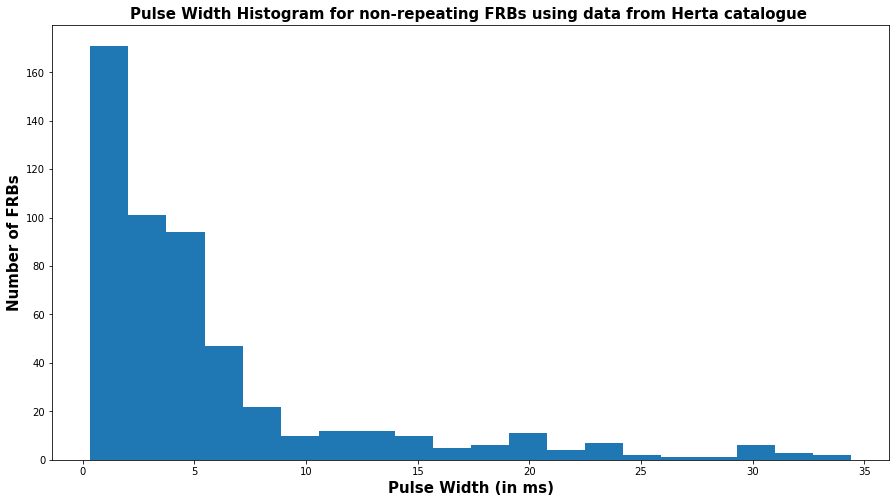

In [55]:
non_rep_pwidthless35

fig, ax_non_reppwidth_herta = plt.subplots(1, 1, figsize = (15, 8))
ax_non_reppwidth_herta.hist(non_rep_pwidthless35, bins = 20)

ax_non_reppwidth_herta.set_ylabel('Number of FRBs', size = 15, weight = 'bold')
ax_non_reppwidth_herta.set_xlabel('Pulse Width (in ms)', size = 15, weight = 'bold')
ax_non_reppwidth_herta.set_title('Pulse Width Histogram for non-repeating FRBs using data from Herta catalogue ', size = 15, weight = 'bold')

plt.savefig('/home/astroguy/Desktop/Research/non_repeater_plot.pdf')
plt.show()

In [ ]:
int_width = [4.78, 23.43, 4.08, 5.16, 0.10, 5.80, 3.33, 2.53, 16.73, 6.46, 2.48, 0.14, 3.70, 1.78, 2.93, 3.04, 4.20, 
            2.53, 6.90, 1.92]

In [ ]:
anderson(int_width)

### Testing author's work with AD test analysis for repeater's data

In [47]:
observed_pwidth = [4.82, 23.45, 4.62, 5.27, 1.01, 5.90, 3.49, 2.75, 16.8, 6.55, 2.71, 1.11, 3.83, 2.10, 3.10, 
                     3.20, 4.50, 2.74, 7.00, 2.18]

intrinsic_pwidth = [4.78, 23.43, 4.08, 5.16, 0.10, 5.80, 3.33, 2.53, 16.73, 6.46, 2.48, 0.14, 3.70, 1.78, 2.93, 
                    3.04, 4.20, 2.53, 6.90, 1.92]

fluence = [0.372, 22.57, 101.54, 1.62, 4.75, 3.45, 1.77, 1.80, 8.50, 1.25, 5.45, 1.70, 0.50, 8.30, 2.75, 2.67, 
          3.10, 6.36, 1.80, 2.03]

distance = [1.61, 0.39, 1.89, 0.58, 0.24, 1.14, 1.42, 1.90, 6.97, 1.66, 1.64, 2.35, 0.62, 2.42, 1.05, 0.77, 7.40,
           1.49, 2.91, 1.07]

luminosity = np.array(fluence)*(np.array(distance)**2)  # Luminosity = fluece * (dist)^2    In table flux density
                                                        # is subsituted with fluence as some flux density values 
                                                        # are missing. 

In [43]:
anderson(np.log(observed_pwidth))

AndersonResult(statistic=0.4297467433047828, critical_values=array([0.506, 0.577, 0.692, 0.807, 0.96 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [44]:
anderson(np.log(intrinsic_pwidth))

AndersonResult(statistic=1.4463782948892572, critical_values=array([0.506, 0.577, 0.692, 0.807, 0.96 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [46]:
anderson(np.log(luminosity))

AndersonResult(statistic=0.3825207521013816, critical_values=array([0.506, 0.577, 0.692, 0.807, 0.96 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:

0.

In [ ]:
1.89**2

### Testing 'anderson' and 'shapiro' function

<class 'numpy.ndarray'>


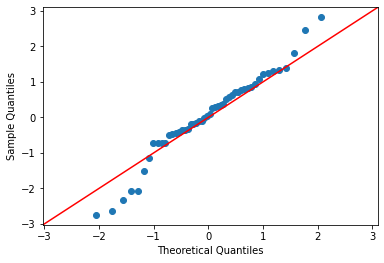

This distribution is a definite normal distribution 



AndersonResult(statistic=0.5807268641594376, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

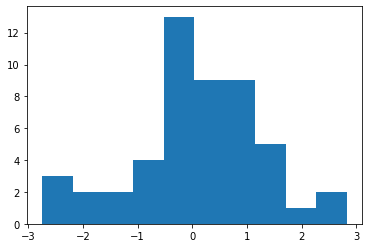

In [79]:
np.random.seed = 0
norm_values = np.random.normal(0, 1, 50)
print(type(norm_values))
fig = sm.qqplot(norm_values, line = '45')
plt.show()
print('This distribution is a definite normal distribution', '\n')
plt.hist(norm_values)
anderson(norm_values)

In [81]:
print('Shapiro test result:')

shapiro(norm_values)

Shapiro test result:


ShapiroResult(statistic=0.9682726860046387, pvalue=0.19669975340366364)

#### Below is a data generated randomly which may or maynot be normal.

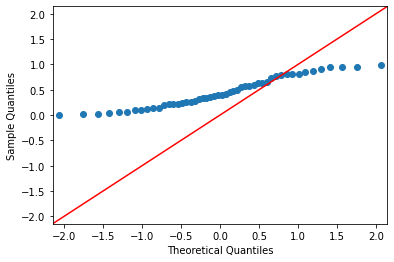

This distribution is not a definite normal distribution but coincidentally maybe one. 



AndersonResult(statistic=0.885713518024076, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

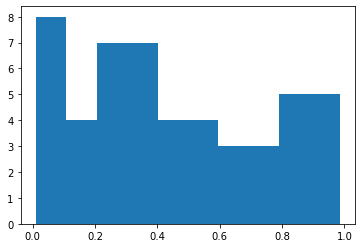

In [37]:
np.random.seed = 0
non_norm_values = np.random.rand(50)
fig = sm.qqplot(non_norm_values, line = '45')
plt.show()
print('This distribution is not a definite normal distribution but coincidentally maybe one.', '\n')
plt.hist(non_norm_values)
anderson(non_norm_values)


In [38]:
shapiro(non_norm_values)

ShapiroResult(statistic=0.9363243579864502, pvalue=0.009664824232459068)